In [1]:
import rasterio
import os
import numpy as np
from shapely.geometry import box
from rasterio.windows import from_bounds, bounds
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib import pyplot

In [2]:
import rasterio
from rasterio.windows import from_bounds, bounds
from shapely.geometry import box

def reproyectar_raster_PP(path_slope = 'DEM/Slope_SRTM_Zone_WGS84.tif', path_pp1 = 'output/2024_09_10.tif', path_name_output = 'output/output_pp.tif'):


      with rasterio.open(path_pp1) as src1, rasterio.open(path_slope) as src2:
        # Obtener la ventana de recorte basada en los límites del GeoTIFF2
        # Con intersección
        
        ext1 = box(*src1.bounds)  # Bordes src1
        ext2 = box(*src2.bounds)  # Bordes src2
        interseccion = ext1.intersection(ext2)  # src1 & src2
        window = from_bounds(*interseccion.bounds,src2.transform)
        
        # Leer los datos de la ventana de recorte
        data = src1.read(window=window)

        # Calcular la transformación para el resampleo
        
        left, bottom, right, top = bounds(window,src2.transform)
        new_transform, width, height = calculate_default_transform(
            src2.crs, src2.crs, data.shape[1], data.shape[0], left, bottom, right, top
        )
        height=window.height
        width=window.width

        # Configurar la metadata para el nuevo GeoTIFF
        kwargs = src2.meta.copy()
        kwargs.update({
            #'transform': new_transform,
            'width': width,
            'height': height
        })

        # Crear un nuevo GeoTIFF para el resampleo
        with rasterio.open(path_name_output, 'w+', **kwargs) as dst:
            # Resamplear el recorte para que coincida con la resolución espacial del GeoTIFF2
            reproject(
                source=data,
                destination=rasterio.band(dst, 1),
                src_transform=src1.window_transform(window),
                src_crs=src1.crs,
                #dst_transform=new_transform,
                dst_crs=src2.crs,
                resampling=Resampling.bilinear

            )
            
reproyectar_raster_PP()

RasterioIOError: output/2024_09_10.tif: No such file or directory

In [3]:
import rasterio
from rasterio.windows import from_bounds, bounds
from shapely.geometry import box

def reproyectar_raster_PP(path_slope = 'DEM/Slope_SRTM_Zone_WGS84.tif', path_pp1 = 'output/2024_09_10.tif', path_name_output = 'output/output_pp.tif'):

    with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext2.intersection(ext1)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1,window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        
        left, bottom, right, top = bounds(window, src2.transform)
        new_transform, width, height = calculate_default_transform(src2.crs, src1.crs, window.width, window.height, left=left, bottom=bottom, right=right, top=top)
        #new_transform = src2.window_transform(window)
        #height = window.height
        #width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(f'Los kawrgs: {kwargs}')
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'src_transform': src2.window_transform(window),
            'resampling': Resampling.bilinear,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)
            
reproyectar_raster_PP()

RasterioIOError: output/2024_09_10.tif: No such file or directory

In [80]:
"""import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds, bounds
from rasterio.warp import calculate_default_transform
from shapely.geometry import box

path_slope = 'Slope_SRTM_Zone_WGS84.tif'
path_pp1 = 'output/2024_09_10.tif'
path_output = 'output/'

with rasterio.open(path_slope) as src1, rasterio.open(path_pp1) as src2:
    ext1 = box(*src1.bounds)
    ext2 = box(*src2.bounds)
    print(f'ext1: {ext1}\next2: {ext2}')
    
    # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
    intersection = ext1.intersection(ext2)
    print(f'intersection: {intersection}')
    
    window = from_bounds(*intersection.bounds, src1.transform)
    print(f'Ventanas: {window}')
    
    # Leer los datos de la ventana de intersección del archivo de precipitación
    data_pp = src2.read(1, window=window)
    print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
    print('bounds:', bounds(window, src1.transform))
    
    left, bottom, right, top = bounds(window, src1.transform)
    new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data_pp.shape[1], data_pp.shape[0],
                                                               left, bottom, right, top)
    height = window.height
    width = window.width
    print(f'La ventana es: {width} X {height}, Teniendo: {window}')
    
    kwargs = src1.meta.copy()
    print(kwargs)
    kwargs.update({
        'width': width,
        'height': height,
        'transform': new_transform,
        'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
    })
    print(f'kwargs: {kwargs}')
    print(window)
    
    # Creación del nuevo archivo TIFF con los datos de precipitación
    with rasterio.open(path_output + 'output_pp.tif', 'w+', **kwargs) as dst:
        print('------------------------------------------\n', data_pp)
        reproject(
            source=data_pp,
            destination=rasterio.band(dst, 1),
            src_transform=src2.window_transform(window),
            src_crs=src2.crs,
            dst_crs=src2.crs,
            dst_transform=new_transform,
            resampling=Resampling.bilinear
        )"""

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 [ 0.          0.83241224  0.6112833  

In [24]:
def reproyectar_raster_slope(path_slope = 'Slope_SRTM_Zone_WGS84.tif', path_pp = 'output/2024_09_12.tif', path_name_output = 'output/output.tif'):
    with rasterio.open(path_slope) as src1, rasterio.open(path_pp) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        # intersection devuelve la geometria que se comparte entre las geometrias de entradas
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        data = src1.read(window=window)
        print(f'Tipo de dato {type(data)}\nDatos: {data}')
        print('bounds:', bounds(window, src1.transform))
        left, bottom, right, top = bounds(window, src1.transform)
        #calculate default transform: (source coor, target coor, width, height, left, bot,right, top)
        #print('src1.crs',src1.crs)
        #print('src2.crs',src2.crs)
        print('data.shape[1]', data.shape[1])
        print('data.shape[2]', data.shape[2])
        new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, data.shape[2], data.shape[1],
                                                                left, bottom, right, top)
        height = window.height
        width = window.width
        #new_transform, width, height = calculate_default_transform(src1.crs, src1.crs, width, height,
        #                                                           left, bottom, right, top)
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height
        })
        print(f'kwargs: {kwargs}')
        print(window)
        # Creación del nuevo path
        with rasterio.open(path_name_output, 'w+', **kwargs) as dst:
            print('------------------------------------------\n',data)
            reproject(
                source=data,
                destination=rasterio.band(dst, 1),
                src_transform=src1.window_transform(window),
                window=window,
                src_crs=src1.crs,
                dst_crs=src2.crs,
                dst_transform=new_transform,
                resampling=Resampling.bilinear
            )
            
reproyectar_raster_slope(path_pp='output/2024_09_10.tif')

RasterioIOError: Slope_SRTM_Zone_WGS84.tif: No such file or directory

In [17]:
path_slope = 'output/output.tif'
path_rosetta = 'Soils/ROSETTA_MEAN/alpha_5-15cm.tif'
path_name_output = 'output/output_alpha.tif'
with rasterio.open(path_slope) as src1, rasterio.open(path_rosetta) as src2:
        ext1 = box(*src1.bounds)
        ext2 = box(*src2.bounds)
        print(f'ext1: {ext1}\next2: {ext2}')
        print(f'CRS1: {src1.crs}')
        print(f'CRS2: {src2.crs}')
        # Intersection devuelve la geometría que se comparte entre las geometrías de entrada
        intersection = ext1.intersection(ext2)
        print(f'intersection: {intersection}')
        
        window = from_bounds(*intersection.bounds, src1.transform)
        print(f'Ventanas: {window}')
        
        # Leer los datos de la ventana de intersección del archivo de precipitación
        data_pp = src2.read(1, window=window)
        print(f'Tipo de dato {type(data_pp)}\nDatos: {data_pp}')
        print('bounds:', bounds(window, src1.transform))
        
        left, bottom, right, top = bounds(window, src1.transform)
        new_transform = src1.window_transform(window)
        height = window.height
        width = window.width
        print(f'La ventana es: {width} X {height}, Teniendo: {window}')
        
        kwargs = src1.meta.copy()
        print(kwargs)
        kwargs.update({
            'width': width,
            'height': height,
            'transform': new_transform,
            'crs': src2.crs  # Asegúrate de que el CRS sea el mismo que el de src2
        })
        print(f'kwargs: {kwargs}')
        print(window)
        
        # Creación del nuevo archivo TIFF con los datos de precipitación
        with rasterio.open(path_name_output, 'w', **kwargs) as dst:
            dst.write(data_pp, 1)

RasterioIOError: output/output.tif: No such file or directory

In [ ]:
# chatgpt funciones.
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def intersect_tiffs(tiff1_path, tiff2_path, output_path):
    """
    Encuentra la intersección entre dos archivos TIFF y crea uno nuevo con los datos del segundo TIFF
    recortados al área de intersección del primero.
    
    Args:
        tiff1_path (str): Ruta al primer archivo TIFF (se usará su extensión)
        tiff2_path (str): Ruta al segundo archivo TIFF (se usarán sus datos)
        output_path (str): Ruta donde se guardará el nuevo TIFF
    """
    
    # Abrir ambos archivos TIFF
    with rasterio.open(tiff1_path) as src1:
        with rasterio.open(tiff2_path) as src2:
            # Obtener los bounds (límites) del primer TIFF
            bounds = src1.bounds
            
            # Verificar si los sistemas de coordenadas son diferentes
            if src1.crs != src2.crs:
                print('CRS diferentes')
                # Calcular la transformación necesaria
                transform, width, height = calculate_default_transform(
                    src2.crs, src1.crs, src2.width, src2.height, *src2.bounds)
                
                # Crear un array temporal para reproyectar
                temp_data = np.zeros((height, width), dtype=src2.dtypes[0])
                
                # Reproyectar los datos del segundo TIFF al CR.S del primero
                reproject(
                    source=rasterio.band(src2, 1),
                    destination=temp_data,
                    src_transform=src2.transform,
                    src_crs=src2.crs,
                    dst_transform=transform,
                    dst_crs=src1.crs,
                    resampling=Resampling.nearest
                )
                
                # Actualizar los metadatos para el archivo reproyectado
                profile = src2.profile.copy()
                profile.update({
                    'crs': src1.crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                # Crear un dataset temporal con los datos reproyectados
                with rasterio.MemoryFile() as memfile:
                    with memfile.open(**profile) as temp_dataset:
                        temp_dataset.write(temp_data, 1)
                        # Realizar el recorte usando los bounds del primer TIFF
                        out_image, out_transform = mask(temp_dataset, 
                                                      [{'type': 'Polygon', 
                                                        'coordinates': [[
                                                            [bounds.left, bounds.bottom],
                                                            [bounds.left, bounds.top],
                                                            [bounds.right, bounds.top],
                                                            [bounds.right, bounds.bottom],
                                                            [bounds.left, bounds.bottom]
                                                        ]]}],
                                                      crop=True)
            else:
                # Si tienen el mismo CRS, hacer el recorte directamente
                print('CRS iguales')
                out_image, out_transform = mask(src2, 
                                              [{'type': 'Polygon', 
                                                'coordinates': [[
                                                    [bounds.left, bounds.bottom],
                                                    [bounds.left, bounds.top],
                                                    [bounds.right, bounds.top],
                                                    [bounds.right, bounds.bottom],
                                                    [bounds.left, bounds.bottom]
                                                ]]}],
                                              crop=True)
            
            # Preparar el perfil para el archivo de salida
            out_profile = src2.profile.copy()
            out_profile.update({
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform
            })
            
            # Guardar el resultado
            with rasterio.open(output_path, 'w', **out_profile) as dest:
                dest.write(out_image)

path_slope = 'output/output.tif'
path_rosetta = 'Soils/PIRange-001/PIRange_Bulkd.30-60cm.tif'
path_name_output = 'output/output_bulkd.tif'
    
intersect_tiffs(path_slope, path_rosetta, path_name_output)

CRS iguales


In [112]:
reproyectar_raster_slope()
#reproyectar_raster_PP()

ext1: POLYGON ((-70.82414754 -41.065264796, -70.82414754 -37.936163569, -74.042230979 -37.936163569, -74.042230979 -41.065264796, -70.82414754 -41.065264796))
ext2: POLYGON ((-68.9459228515625 -36.313880920410156, -68.9459228515625 -48.062965393066406, -78.54290771484375 -48.062965393066406, -78.54290771484375 -36.313880920410156, -68.9459228515625 -36.313880920410156))
intersection: POLYGON ((-74.042230979 -41.065264796, -74.042230979 -37.936163569, -70.82414754 -37.936163569, -70.82414754 -41.065264796, -74.042230979 -41.065264796))
Ventanas: Window(col_off=0.0, row_off=0.0, width=11592.0, height=11262.0)
Tipo de dato <class 'numpy.ndarray'>
Datos: [[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]
bounds: (-74.042230979, -41.06526

# ----------------------------------------

In [131]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
output_tif_path = 'output/output_alpha.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')
    print(np.unique(data_window))
    
    

Metadatos:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3219, 'height': 3130, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0010000000000000005, 0.0, -74.042306662,
       0.0, -0.0009999999999999998, -37.93587467999999)}
Datos:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Width: 3219
Height: 3130
Ventana:  Window(col_off=0.0, row_off=0.0, width=3219.0, height=3130.0000000000073)
Datos de la ventana:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Row: 2337
Col: 473
Valor en (-73.5688,-40.2737): 0.010999999940395355
[0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012 0.013 0.014
 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024 0.027 0.028
   

Metadatos:  {'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 323, 'height': 313, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.01, 0.0, -74.042230979,
       0.0, -0.01, -37.94526479600062)}
Datos:  [[0.00254682 0.00138394 0.00113316 ... 0.01159122 0.01276619 0.        ]
 [0.00042642 0.00108323 0.00245981 ... 0.01276619 0.01276619 0.        ]
 [0.00074452 0.00060409 0.00074852 ... 0.01162505 0.01162505 0.        ]
 ...
 [0.0398136  0.03981402 0.0398136  ... 0.00785401 0.01136311 0.        ]
 [0.00785401 0.00785401 0.0078541  ... 0.00785401 0.00732512 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Width: 323
Height: 313
Ventana:  Window(col_off=0.0, row_off=0.0, width=323.0, height=313.0000000000009)
Datos de la ventana:  [[0.00254682 0.00138394 0.00113316 ... 0.01159122 0.01276619 0.        ]
 [0.00042642 0.00108323 0.00245981 ... 0.01276619 0.01276619 0.        ]
 [0.00074452 0.00060409 0.00074852 ... 0.01162505 0.0

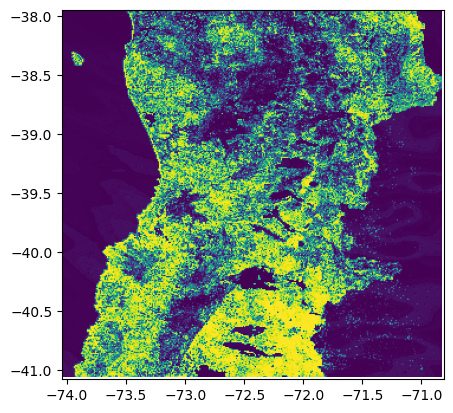

Row: 232
Col: 47
Valor en (-73.5688,-40.2737): 0.3195135119593549
[0.00000000e+00 2.23859443e-05 2.79073612e-05 ... 9.99931983e-01
 9.99946843e-01 9.99955747e-01]


In [5]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show, show_hist
output_tif_path = 'Output_01/tif/probability/raster_proba_2024_09_09.tif'

with rasterio.open(output_tif_path) as src:
    meta = src.meta
    print('Metadatos: ',meta)
    data = src.read(1)
    print('Datos: ',data)
    width = meta['width']
    height = meta['height']
    print(f'Width: {width}\nHeight: {height}')
    window = src.window(*src.bounds)
    print('Ventana: ',window)
    data_window = src.read(1, window=window)
    print('Datos de la ventana: ',data_window)
    show(src, transform=src.transform, cmap='viridis')
    #lon, lat = -73.219497,-37.7517708

    lon,lat = -73.5688,-40.2737
    row, col = src.index(lon, lat)
    print(f'Row: {row}\nCol: {col}')
    value = data_window[row,col]
    print(f'Valor en ({lon},{lat}): {value}')    
    print(np.unique(data_window))

C:\Users\ivo\AppData\Local\Temp\ipykernel_18712\2787172468.py:31: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(


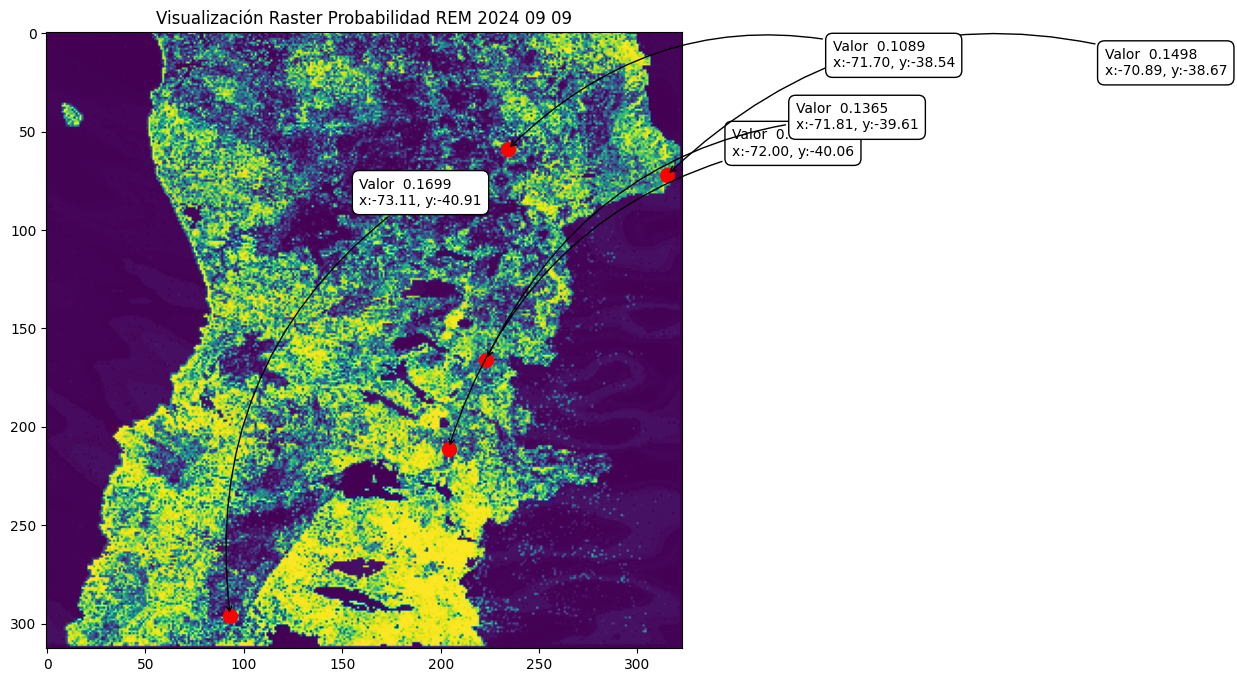

In [49]:
import matplotlib.pyplot as plt
import numpy as np

import rasterio
from rasterio.plot import show_hist, show
from matplotlib import pyplot
output_tif_path = 'Output_01/tif/probability/raster_proba_2024_09_09.tif'
src = rasterio.open(output_tif_path)

with rasterio.open(output_tif_path) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs

mask = (raster_data>= 0.1) & (raster_data < 0.2)
potential_points = np.argwhere(mask)

indices = np.random.choice(len(potential_points), 5, replace=False)
selected_points = potential_points[indices]

plt.figure(figsize=(12,8))
plt.imshow(raster_data)
#plt.colorbar(label='Valor')
plt.title(f"Visualización Raster Probabilidad REM 2024 09 09")

for point in selected_points:
    y,x = point
    value = raster_data[y,x]
    geo_x, geo_y = rasterio.transform.xy(transform,y,x)
    plt.plot(x,y,'ro',markersize=10)
    plt.annotate(
        f'Valor {value: .4f}\nx:{geo_x: .2f}, y:{geo_y: .2f}',
        (x,y),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.3'),
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=1)
    )



In [2]:
import rasterio
import pandas as pd
import numpy as np
from tqdm import tqdm

def tif_to_dataframe(tif_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        
        height, width = data.shape
        
        latitudes = []
        longitudes = []
        values = []
        
        # Iterar sobre cada píxel del raster
        for row in tqdm(range(height)):
            for col in range(width):
                
                lon, lat = src.xy(row, col)
                
                value = data[row, col]
                
                latitudes.append(lat)
                longitudes.append(lon)
                values.append(value)
        
        df = pd.DataFrame({
            'Latitud': latitudes,
            'Longitud': longitudes,
            'Value': values
        })
        
        return df

tif_path = 'output/output.tif'
df = tif_to_dataframe(tif_path)
print(df.head())

#obtención de dataframe valores slope, latitud y longitud
# a partir de estas latitudes y longitudes se obtendrán los valores de los otros tif

100%|██████████| 11262/11262 [54:58<00:00,  3.41it/s] 


    Latitude  Longitude   Value
0 -37.936302 -74.042092 -9999.0
1 -37.936302 -74.041815 -9999.0
2 -37.936302 -74.041537 -9999.0
3 -37.936302 -74.041259 -9999.0
4 -37.936302 -74.040982 -9999.0


In [7]:
import numpy as np
df = pd.read_csv('lat_lon_slope.csv', index=False)
df.Value.replace("-9999", np.nan, inplace=True)

C:\Users\ivo\AppData\Local\Temp\ipykernel_24876\731091974.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Value.replace("-9999", np.nan, inplace=True)


,Latitude,Longitude,Value
0,-37.936302,-74.042092,-9999.0
1,-37.936302,-74.041815,-9999.0
2,-37.936302,-74.041537,-9999.0
3,-37.936302,-74.041259,-9999.0
4,-37.936302,-74.040982,-9999.0
...,...,...,...
130549099,-41.065126,-70.825397,-9999.0
130549100,-41.065126,-70.825119,-9999.0
130549101,-41.065126,-70.824842,-9999.0
130549102,-41.065126,-70.824564,-9999.0


In [10]:
df.loc[df.Value == -9999, 'Value'] = np.nan
df.isna().sum()

Latitude           0
Longitude          0
Value        7208393
dtype: int64

In [3]:
import pandas as pd
def values_from_df(df: pd.DataFrame, tif_path: list) -> pd.DataFrame:
    
    for path in tif_path:
        with rasterio.open(path) as src:
            data = src.read(1)
            height, width = data.shape
            values = []
            for index, row in df.iterrows():
                lon = row['Longitud']
                lat = row['Latitud']
                row, col = src.index(lon, lat)
                value = data[row, col]
                values.append(value)
            df[path] = values
                

In [12]:
import matplotlib.pyplot as plt

df_filterded = df[(df['Value'] >= 0) & (df['Value'] <= 80)]
ax = df_filterded['Value'].hist(bins=20, edgecolor='black', grid=False, figsize=(20, 16))

for patch in ax.patches:
    bin_value = patch.get_height()
    if bin_value > 0:  
        plt.annotate(f'{bin_value:.0f}', 
                     (patch.get_x() + patch.get_width() / 2, patch.get_height()), 
                     ha='center', va='bottom')

print(df.shape)


KeyboardInterrupt



In [4]:
import numpy as np

from osgeo import gdal, gdalconst, osr
from netCDF4 import Dataset

In [ ]:
def nc_to_tif(nc_file_path = 'WRFProno_20240908181246.nc'):
    # convertir archivo nc a tif
    nc_file = Dataset(nc_file_path, 'r')

    lon = nc_file.variables['XLONG'][:]
    lat = nc_file.variables['XLAT'][:]
    lon_min, lon_max = lon.min(), lon.max()
    lat_min, lat_max = lat.min(), lat.max()
    print(f'Latitud {lat_min} {lat_max}')
    print(f'Longitud {lon_min} {lon_max}')

    cols, rows = len(lon[0]), len(lat[0])
    rainnc = nc_file.variables['RAINNC']
    cols, rows = np.size(rainnc[0], 1), np.size(rainnc[0], 0)
    dx = (lon_max - lon_min) / cols
    dy = (lat_max - lat_min) / rows
    transform = [lon_min, dx, 0, lat_min, 0, dy]

    
    string_date = []

    for time_index, timestamp_bytes in enumerate(nc_file.variables['Times']):
        timestamp_str = b''.join(timestamp_bytes).decode('utf-8')
        string_date.append(timestamp_str[:10])

    fec_uni = set(string_date)
    print(fec_uni)
    for ind in fec_uni:
        ind_fec = [indice for indice, valor in enumerate(string_date) if valor == ind]
        print(max(ind_fec), min(ind_fec))
        if min(ind_fec) > 0:
            data1 = rainnc[max(ind_fec), :, :] - rainnc[min(ind_fec)-1, :, :]
        else:
            data1 = rainnc[max(ind_fec), :, :]
        print(data1.shape)
        
        output_tif_path = fr'output/{ind[:4]}_{ind[5:7]}_{ind[8:10]}.tif'    
        driver = gdal.GetDriverByName('GTiff')
        print(f'rows, cols: {output_tif_path} {rows} {cols}')
        output_tiff = driver.Create(output_tif_path, cols,rows,  1, gdal.GDT_Float32)

        output_tiff.SetGeoTransform(transform)
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326)
        output_tiff.SetProjection(srs.ExportToWkt())
        print('-'*20,np.flipud(data1))
        #data = np.flipud(data1) # No entiendo
        data = data1
        output_tiff.GetRasterBand(1).WriteArray(data)
        output_tiff = None
    nc_file.close()
    

nc_to_tif()

Latitud -48.062965393066406 -36.313880920410156
Longitud -78.54290771484375 -68.9459228515625
{'2024-09-10', '2024-09-09', '2024-09-11', '2024-09-12', '2024-09-13', '2024-09-08'}
59 36
(213, 120)
rows, cols: output/2024_09_10.tif 213 120
-------------------- [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.83241224  0.6112833  ... 33.386032   36.16939
   0.        ]
 [ 0.          0.6890626   0.49410963 ... 33.14177    35.983006
   0.        ]
 ...
 [ 0.          0.24050066  0.18175383 ...  0.          0.
   0.        ]
 [ 0.          0.23380588  0.22872874 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
35 12
(213, 120)
rows, cols: output/2024_09_09.tif 213 120
-------------------- [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.9396749e+00 2.0101240e+00 ... 1.9958555e+00
  2.4097159e+00 0.0000000e+00]
 [0.0000000e+00 2.24

In [2]:
import pickle
import os
def load_models_and_features(model_path: str):
    # Carga el modelo y las caracteristicas a utilizar
    # output:
    #   model: sklearn.model_selection
    #   features: listv
    with open(model_path, 'rb') as model_file:
        model = pickle.load(model_file)
    features = model.best_estimator_.feature_names_
    return model, features

def data_from_features_model(features: list, PATH = 'Soils/'):
    # Primero voy a crear una lista de todos los archivos que están dentro de cada carpeta de la
    # carpeta de Soils/
    # ej: Abrir Soils Abrir 'ROSETTA_MEAN' crear lista de todos los archivos dentro de 'ROSETTA_MEAN'
    
    # Se obtienen las carpetas dentro de SOILS/
    files = [f for f in os.listdir(PATH)]    
    
    # Ahora creo un diccionario donde a partir del nombre de la carpeta se obtengan todos los
    # tif que estan dentro de esta
    files_dict = {file: os.listdir(PATH + '/' + file) for file in files}
    # ahora de esta forma podemos pedir las features del modelo y verificamos a traves del diccionario
    # donde estan ubicada cada feature para de esta forma obtener los datos necesarios
    #path_file = []
    path_file = [k +'/'+i for k,v in files_dict.items() for i in v if i in features]
    print('-'*50)
    print(f'path de cada archivo: {path_file}\n')
    
    # Ahora a partir de la entrada features: list se obtendran los path necesarios para luego extraer
    # cada dato necesario de los tif
    
    # crear lista de paths, a cada feature le corresponde un path dentro de la lista paths
    # ciclo para abrir tif para cada paths
    # PREGUNTAR: como obtengo los pixeles (o lat lon)
    return path_file


In [3]:
model, features = load_models_and_features('models/catboost_model_random_search.pkl')
print(f'Modelo: {type(model)}\n')
print(f'Caracteristicas: {features}\n')
print(f'Cantidad de caracteristcas: {len(features)}')
    
path_files = data_from_features_model(features=features)
print(type(path_files))
print(f'Los path de todos los files {path_files}')

Modelo: <class 'sklearn.model_selection._search.RandomizedSearchCV'>

Caracteristicas: ['slope', 'valor_humedad_suelo1', 'PP', 'PIRange_Clay.15-30cm.tif', 'ksat_60-100cm.tif', 'n_60-100cm.tif', 'n_15-30cm.tif', 'n_5-15cm.tif', 'PIRange_Clay.0-5cm.tif', 'alpha.0-5cm.tif', 'PIRange_Clay.5-15cm.tif', 'PIRange_Bulkd.100-200cm.tif', 'PIRange_Bulkd.5-15cm.tif', 'PIRange_Sand.0-5cm.tif', 'PIRange_Sand.15-30cm.tif', 'Bulkd.5-15cm.tif', 'ksat_100-200cm.tif', 'PIRange_Sand.100-200cm.tif', 'ksat_15-30cm.tif', 'Bulkd.100-200cm.tif']

Cantidad de caracteristcas: 20
--------------------------------------------------
path de cada archivo: ['PIRange-001/PIRange_Bulkd.100-200cm.tif', 'PIRange-001/PIRange_Bulkd.5-15cm.tif', 'PIRange-001/PIRange_Clay.0-5cm.tif', 'PIRange-001/PIRange_Clay.15-30cm.tif', 'PIRange-001/PIRange_Clay.5-15cm.tif', 'PIRange-001/PIRange_Sand.0-5cm.tif', 'PIRange-001/PIRange_Sand.100-200cm.tif', 'PIRange-001/PIRange_Sand.15-30cm.tif', 'ROSETTA_MEAN/ksat_100-200cm.tif', 'ROSETTA_MEA

c:\Users\ivo\.conda\envs\rasterio\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
path_files = ['Soils/' + path for path in path_files]
path_files

['Soils/PIRange-001/PIRange_Bulkd.100-200cm.tif',
 'Soils/PIRange-001/PIRange_Bulkd.5-15cm.tif',
 'Soils/PIRange-001/PIRange_Clay.0-5cm.tif',
 'Soils/PIRange-001/PIRange_Clay.15-30cm.tif',
 'Soils/PIRange-001/PIRange_Clay.5-15cm.tif',
 'Soils/PIRange-001/PIRange_Sand.0-5cm.tif',
 'Soils/PIRange-001/PIRange_Sand.100-200cm.tif',
 'Soils/PIRange-001/PIRange_Sand.15-30cm.tif',
 'Soils/ROSETTA_MEAN/ksat_100-200cm.tif',
 'Soils/ROSETTA_MEAN/ksat_15-30cm.tif',
 'Soils/ROSETTA_MEAN/ksat_60-100cm.tif',
 'Soils/ROSETTA_MEAN/n_15-30cm.tif',
 'Soils/ROSETTA_MEAN/n_5-15cm.tif',
 'Soils/ROSETTA_MEAN/n_60-100cm.tif',
 'Soils/ROSETTA_SD/alpha.0-5cm.tif',
 'Soils/SoilMaps_MEAN/Bulkd.100-200cm.tif',
 'Soils/SoilMaps_MEAN/Bulkd.5-15cm.tif']

In [5]:
import rasterio
import pandas as pd
import numpy as np
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from functools import partial

def tif_to_dataframe_with_window_parallel(reference_tif: str, tif_paths: list[str]):
    def process_tif(args):
        tif_path, longs, lats, ref_crs = args
        with rasterio.open(tif_path) as src:
            if src.crs != ref_crs:
                raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")
            # Vectorized sampling
            values = np.array([x[0] if x else np.nan for x in src.sample(zip(longs, lats))])
            return tif_path.split('/')[-1], values

    with rasterio.open(reference_tif) as ref_src:
        
        meta = ref_src.meta
        ref_array = ref_src.read(1)
        ref_transform = ref_src.transform
        height = meta['height']
        width = meta['width']
        #mask = ref_array != ref_src.nodatavals[0]
        #rows, cols = np.where(mask)
        print('Realizando meshgrid...')
        rows, cols = np.meshgrid(range(height), range(width), indexing='ij')
        print(f'rows: {rows.flatten()}\ncols: {cols.flatten()}')
        print('Realizando transform desde xy...')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows.flatten(), cols.flatten())
        # Get coordinates
        longitudes = np.array(xs)
        latitudes = np.array(ys)
        
        # Combine all paths
        all_paths = tif_paths + ['output/output.tif', 'output/output_pp.tif']
        
        # Prepare arguments for parallel processing
        args = [(path, longitudes, latitudes, ref_src.crs) for path in all_paths]
        
        # Process in parallel
        with ThreadPoolExecutor(max_workers=mp.cpu_count()-1) as executor:
            results = list(tqdm(
                executor.map(lambda x: process_tif(x), args),
                total=len(all_paths),
                desc="Procesando archivos"
            ))
        
        # Create DataFrame
        data = {
            'Latitude': latitudes,
            'Longitude': longitudes,
            **dict(results)
        }
        
        return pd.DataFrame(data)

reference_tif = 'output/output.tif'
tif_list = path_files
df = tif_to_dataframe_with_window_parallel(reference_tif, tif_list)
df.to_csv('model_features_df.csv', index=False)

Realizando meshgrid...
rows: [    0     0     0 ... 11261 11261 11261]
cols: [    0     1     2 ... 11589 11590 11591]
Realizando transform desde xy...


Procesando archivos: 100%|██████████| 19/19 [32:07:44<00:00, 6087.62s/it]    


In [ ]:
import rasterio
import pandas as pd
import numpy as np
from tqdm import tqdm

def tif_to_dataframe_with_window(reference_tif_path: str, tif_paths: list) -> pd.DataFrame:

    # Abrir el TIF de referencia para obtener las coordenadas
    with rasterio.open(reference_tif_path) as ref_src:
        meta = ref_src.meta
        ref_array = ref_src.read(1)
        ref_transform = ref_src.transform
        height = meta['height']
        width = meta['width']
        #mask = ref_array != ref_src.nodatavals[0]
        #rows, cols = np.where(mask)
        print('Realizando meshgrid...')
        rows, cols = np.meshgrid(range(height), range(width), indexing='ij')
        print(f'rows: {rows.flatten()}\ncols: {cols.flatten()}')
        print('Realizando transform desde xy...')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows.flatten(), cols.flatten())
        #print(f'Filas: {rows}\nColumnas: {cols}')

        # Obtener coordenadas
        #xs, ys = rasterio.transform.xy(ref_transform, rows, cols)
        longitudes = np.array(xs)
        latitudes = np.array(ys)
        print(f'Longitudes: {longitudes}\nLatitudes: {latitudes}')
    data = {'Latitude': latitudes, 'Longitude': longitudes}

    for tif_path in tif_paths:
        values = []
        print("Comenzando a extraer valores de", tif_path)
        with rasterio.open(tif_path) as src:
            if src.crs != ref_src.crs:
                raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")

            for val in tqdm(src.sample(zip(longitudes, latitudes))):
                values.append(val[0] if val else np.nan)

        tif_name = tif_path.split('/')[-1]
        data[tif_name] = values
    
    # agregar valores de slope y pp    
    list_path = ['output/output.tif', 'output/output_pp.tif']
    for tif_path in list_path:
        values = []
        print("Comenzando a extraer valores de", tif_path)
        with rasterio.open(tif_path) as src:
            if src.crs != ref_src.crs:
                raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")

            for val in tqdm(src.sample(zip(longitudes, latitudes))):
                values.append(val[0] if val else np.nan)

        tif_name = tif_path.split('/')[-1]
        data[tif_name] = values
    df = pd.DataFrame(data)
    return df

reference_tif = 'output/output.tif'
tif_list = path_files

df = tif_to_dataframe_with_window(reference_tif, tif_list)
print(df.head())

df.to_csv('model_features_df.csv', index=False)

Realizando meshgrid...
rows: [    0     0     0 ... 11261 11261 11261]
cols: [    0     1     2 ... 11589 11590 11591]
Realizando transform desde xy...
Longitudes: [-74.04209217 -74.04181456 -74.04153695 ... -70.82484157 -70.82456396
 -70.82428635]
Latitudes: [-37.93630249 -37.93630249 -37.93630249 ... -41.06512587 -41.06512587
 -41.06512587]


  0%|          | 0/17 [00:00<?, ?it/s]

Comenzando a extraer valores de Soils/PIRange-001/PIRange_Bulkd.100-200cm.tif


99982340it [1:19:49, 20876.94it/s]
  0%|          | 0/17 [1:19:49<?, ?it/s]


In [14]:
def add_tif_values_to_df(df: pd.DataFrame, reference_tif: str, tif_paths: list[str]) -> pd.DataFrame:
    with rasterio.open(reference_tif) as ref_src:
        longitudes = df['Longitude'].values
        latitudes = df['Latitude'].values
        
        for tif_path in tif_paths:
            print("Comenzando a extraer valores de", tif_path)
            with rasterio.open(tif_path) as src:
                if src.crs != ref_src.crs:
                    raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")
                
                values = []
                for val in tqdm(src.sample(zip(longitudes, latitudes))):
                    values.append(val[0] if val else np.nan)
                
                tif_name = tif_path.split('/')[-1]
                df[tif_name] = values
    
    return df

reference_tif = 'output/output.tif'
tif_list = ['output/output.tif', 'output/output_pp.tif']
add_tif_values_to_df(df=df, reference_tif=reference_tif, tif_paths=tif_list)

Comenzando a extraer valores de output/output.tif


123340711it [03:53, 527362.95it/s]


Comenzando a extraer valores de output/output_pp.tif


27623490it [21:39, 21249.04it/s]


KeyboardInterrupt: 

In [ ]:
def df_in_model_to_proba(df: pd.DataFrame, model):
    X = df.drop(columns=['Latitude', 'Longitude'])
    proba = model.predict_proba(X)
    return proba

def proba_in_df(df: pd.DataFrame, proba: np.array) -> pd.DataFrame:
    df['Probabilidad'] = proba[:, 1]
    return df

def save_df_to_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)

def proba_to_tif(df: pd.Dataframe, reference_tif: str, path_output: str):
    with rasterio.open(reference_tif) as ref_src:
        meta = ref_src.meta
        height = meta['height']
        width = meta['width']
        proba = df['Probabilidad'].values
        proba = proba.reshape(height, width)
        with rasterio.open(path_output, 'w', **meta) as dst:
            dst.write(proba, 1)

In [1]:
import pandas as pd
#df = pd.read_csv('model_features_df.csv')
#df

In [2]:
from model_raster import tif_to_dataframe_with_window_parallel
reference_tif = 'output/tif/output_pp.tif'
tif_paths = []
#df_slope_PP = tif_to_dataframe_with_window_parallel(reference_tif, tif_paths)
#save_df_to_csv(df_slope_PP, 'model_features_df_slope_PP.csv')

In [3]:
def fast_extract_raster_values(reference_tif: str, target_tifs: list[str]) -> pd.DataFrame:
    """
    Creates a grid of lat/lon coordinates and extracts values from multiple rasters
    Returns: DataFrame with lat, lon and values from each raster
    """
    with rasterio.open(reference_tif) as ref_src:
        # Get bounds
        bounds = ref_src.bounds
        print(f"Bounds: {bounds}")
        
        # Create coordinate grid with 0.001 spacing
        lons = np.arange(bounds.left, bounds.right, 0.01)
        lats = np.arange(bounds.bottom, bounds.top, 0.01)
        
        # Agregar los tif de referencia de slope y PP 
        target_tifs = ['output/output.tif', 'output/output_pp.tif'] + target_tifs
        
        # Create meshgrid and flatten
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        coords = list(zip(lon_grid.flatten(), lat_grid.flatten()))
        
        print(f"Generated {len(coords)} coordinate pairs")

        def sample_tif(tif_path):
            with rasterio.open(tif_path) as src:
                if src.crs != ref_src.crs:
                    raise ValueError(f"CRS mismatch: {tif_path}")
                    
                # Sample values at coordinates
                values = [x[0] if x else np.nan for x in src.sample(coords)]
                return tif_path.split('/')[-1], values

        # Process in parallel
        with ThreadPoolExecutor(max_workers=mp.cpu_count()-1) as executor:
            results = list(tqdm(
                executor.map(sample_tif, target_tifs),
                total=len(target_tifs),
                desc="Sampling rasters"
            ))
            
        # Create DataFrame
        df = pd.DataFrame({
            'Longitude': [c[0] for c in coords],
            'Latitude': [c[1] for c in coords],
        })
        
        # Add raster values
        for name, values in results:
            df[name] = values
            
        print(f"Final DataFrame shape: {df.shape}")
        return df

In [21]:
from model_raster import *
path_model = 'models/catboost_model_random_search.pkl'
model, features = load_models_and_features(path_model)
path_files = data_from_features_model(features=features)
path_files = ['Soils/' + path for path in path_files]
vals = fast_extract_raster_values(reference_tif, path_files)

c:\Users\ivo\.conda\envs\rasterio\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomizedSearchCV from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


--------------------------------------------------
path de cada archivo: ['PIRange-001/PIRange_Bulkd.100-200cm.tif', 'PIRange-001/PIRange_Bulkd.5-15cm.tif', 'PIRange-001/PIRange_Clay.0-5cm.tif', 'PIRange-001/PIRange_Clay.15-30cm.tif', 'PIRange-001/PIRange_Clay.5-15cm.tif', 'PIRange-001/PIRange_Sand.0-5cm.tif', 'PIRange-001/PIRange_Sand.100-200cm.tif', 'PIRange-001/PIRange_Sand.15-30cm.tif', 'ROSETTA_MEAN/ksat_100-200cm.tif', 'ROSETTA_MEAN/ksat_15-30cm.tif', 'ROSETTA_MEAN/ksat_60-100cm.tif', 'ROSETTA_MEAN/n_15-30cm.tif', 'ROSETTA_MEAN/n_5-15cm.tif', 'ROSETTA_MEAN/n_60-100cm.tif', 'ROSETTA_SD/alpha.0-5cm.tif', 'SoilMaps_MEAN/Bulkd.100-200cm.tif', 'SoilMaps_MEAN/Bulkd.5-15cm.tif']

Bounds: BoundingBox(left=-74.042230979, bottom=-41.065264796, right=-70.82414754, top=-37.936163569)
Generated 100786 coordinate pairs


Sampling rasters: 100%|██████████| 19/19 [01:28<00:00,  4.68s/it]


Final DataFrame shape: (100786, 21)


In [25]:
vals

,Longitude,Latitude,output.tif,output_pp.tif,PIRange_Bulkd.100-200cm.tif,PIRange_Bulkd.5-15cm.tif,PIRange_Clay.0-5cm.tif,PIRange_Clay.15-30cm.tif,PIRange_Clay.5-15cm.tif,PIRange_Sand.0-5cm.tif,...,PIRange_Sand.15-30cm.tif,ksat_100-200cm.tif,ksat_15-30cm.tif,ksat_60-100cm.tif,n_15-30cm.tif,n_5-15cm.tif,n_60-100cm.tif,alpha.0-5cm.tif,Bulkd.100-200cm.tif,Bulkd.5-15cm.tif
0,-74.042231,-41.065265,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-74.032231,-41.065265,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-74.022231,-41.065265,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-74.012231,-41.065265,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-74.002231,-41.065265,-9999.0,-9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100781,-70.872231,-37.945265,-9999.0,8.178168,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100782,-70.862231,-37.945265,-9999.0,8.870686,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100783,-70.852231,-37.945265,-9999.0,9.563203,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100784,-70.842231,-37.945265,-9999.0,10.255720,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
import numpy as np
df = vals
df = df.rename(columns={
    'output.tif': 'slope',
    'output_pp.tif': 'PP'
})
n_samples = len(df)
random_values = np.random.normal(loc=0.45, scale=0.1, size=n_samples)
df.insert(2, 'valor_humedad_suelo1', random_values)
df['slope'] = df['slope'].replace(-9999, np.nan)
df['PP'] = df['PP'].replace(-9999, np.nan)
df = df.fillna(df.mean())
proba = df_in_model_to_proba(df , model)
df = proba_in_df(df, proba)
df_output = 'output/csv/model_latlon_method_w_proba.csv'
save_df_to_csv(df = df, path = df_output)
# df con probabilidad guardado en /output/csv/model_data_features.csv
print('-'*50)
print('df guardado con probabilidad')
print('-'*50)
    

--------------------------------------------------
df guardado con probabilidad
--------------------------------------------------


In [44]:
model.best_estimator_.feature_names_

['slope',
 'valor_humedad_suelo1',
 'PP',
 'PIRange_Clay.15-30cm.tif',
 'ksat_60-100cm.tif',
 'n_60-100cm.tif',
 'n_15-30cm.tif',
 'n_5-15cm.tif',
 'PIRange_Clay.0-5cm.tif',
 'alpha.0-5cm.tif',
 'PIRange_Clay.5-15cm.tif',
 'PIRange_Bulkd.100-200cm.tif',
 'PIRange_Bulkd.5-15cm.tif',
 'PIRange_Sand.0-5cm.tif',
 'PIRange_Sand.15-30cm.tif',
 'Bulkd.5-15cm.tif',
 'ksat_100-200cm.tif',
 'PIRange_Sand.100-200cm.tif',
 'ksat_15-30cm.tif',
 'Bulkd.100-200cm.tif']

In [60]:
df['Probabilidad'].describe()

count    100786.000000
mean          0.182878
std           0.294129
min           0.000007
25%           0.001794
50%           0.017882
75%           0.234395
max           0.999916
Name: Probabilidad, dtype: float64

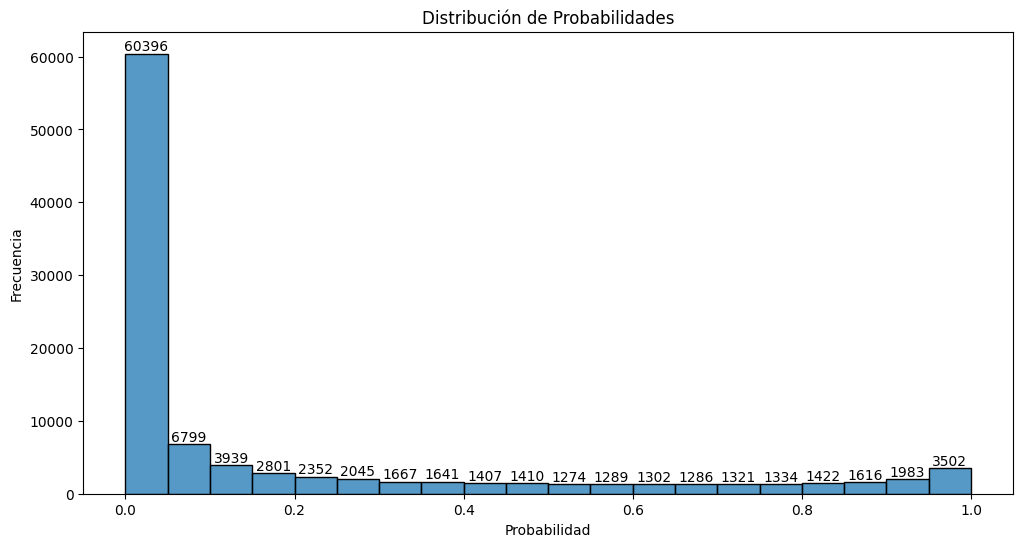

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='Probabilidad', bins=20, edgecolor='black')

for patch in ax.patches:
    height = patch.get_height()
    center = patch.get_x() + patch.get_width()/2
    ax.text(center, height, 
                f'{int(height)}', 
                ha='center', 
                va='bottom')

plt.title('Distribución de Probabilidades')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.show()

In [19]:
model.best_estimator_.feature_importances_

array([ 9.04007631, 12.03849611, 14.56080665,  4.82914548,  4.37592948,
        4.50256627,  4.08487019,  5.32716095,  4.27990723,  3.79837928,
        4.04808579,  3.95759922,  3.39102344,  3.49791504,  2.61685381,
        4.68710178,  2.0960068 ,  2.47654363,  3.68605952,  2.70547303])

In [53]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

def points_to_raster(df, output_path='output/tif/probability.tif', resolution=0.01):
    """Convert points DataFrame to raster TIF"""
    
    # Get bounds
    left = df['Longitude'].min()
    right = df['Longitude'].max()
    bottom = df['Latitude'].min()
    top = df['Latitude'].max()
    
    # Calculate dimensions (add +1 to include last point)
    width = int(np.ceil((right - left) / resolution)) + 1
    height = int(np.ceil((top - bottom) / resolution)) + 1
    
    print(f"Raster dimensions: {width} x {height}")
    print(f"DataFrame points: {len(df)}")
    
    # Create empty raster
    raster = np.zeros((height, width))
    
    # Create affine transform
    transform = from_origin(left, top, resolution, resolution)
    
    # Convert points to pixel coordinates
    col_indices = ((df['Longitude'] - left) / resolution).astype(int)
    row_indices = ((top - df['Latitude']) / resolution).astype(int)
    
    # Validate indices
    valid_idx = (
        (row_indices >= 0) & (row_indices < height) & 
        (col_indices >= 0) & (col_indices < width)
    )
    
    if not valid_idx.all():
        print(f"Warning: {(~valid_idx).sum()} points outside raster bounds")
    
    # Assign probability values only for valid indices
    raster[row_indices[valid_idx], col_indices[valid_idx]] = df.loc[valid_idx, 'Probabilidad']
    
    # Define metadata
    metadata = {
        'driver': 'GTiff',
        'height': height,
        'width': width,
        'count': 1,
        'dtype': raster.dtype,
        'crs': 'EPSG:4326',  # WGS84
        'transform': transform,
        'nodata': 0
    }
    
    # Write to file
    with rasterio.open(output_path, 'w', **metadata) as dst:
        dst.write(raster, 1)
    
    print(f"Raster saved to {output_path}")
    return output_path

In [54]:
points_to_raster(df)

Raster dimensions: 323 x 313
DataFrame points: 100786
Raster saved to output/tif/probability.tif


'output/tif/probability.tif'

In [ ]:

def extract_values_from_tifs(reference_tif: str, target_tifs: list[str], n_workers: int = None) -> pd.DataFrame:
    """Extract values from multiple TIFs at reference TIF points"""
    def process_tif(args):
        tif_path, coords, ref_crs = args
        with rasterio.open(tif_path) as src:
            if src.crs != ref_crs:
                raise ValueError(f"CRS mismatch: {tif_path}")
            # Add progress bar for point sampling
            values = np.array([
                x[0] if x else np.nan 
                for x in tqdm(src.sample(coords), 
                            total=len(coords),
                            desc=f"Sampling {tif_path.split('/')[-1]}",
                            leave=False)
            ])
            return tif_path.split('/')[-1], values

    print("Iniciando extracción de valores...")
    with rasterio.open(reference_tif) as ref:
        # Get reference points with progress
        height, width = ref.height, ref.width
        with tqdm(desc="Creando coordenadas", total=1) as pbar:
            rows, cols = np.meshgrid(range(height), range(width), indexing='ij')
            xs, ys = rasterio.transform.xy(ref.transform, rows.flatten(), cols.flatten())
            coords = list(zip(xs, ys))
            pbar.update(1)
        
        n_workers = n_workers or (mp.cpu_count() - 1)
        args = [(tif, coords, ref.crs) for tif in target_tifs]
        
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            results = list(tqdm(
                executor.map(lambda x: process_tif(x), args),
                total=len(target_tifs),
                desc="Procesando archivos TIF"
            ))
        
        df = pd.DataFrame({
            'Longitud': xs,
            'Latitud': ys,
            **dict(results)
        })
        
        return df

In [ ]:

def tif_to_dataframe_with_window_parallel(reference_tif: str, tif_paths: list[str]):
    def process_tif(args):
        tif_path, longs, lats, ref_crs = args
        with rasterio.open(tif_path) as src:
            if src.crs != ref_crs:
                raise ValueError(f"El CRS de {tif_path} no coincide con el del TIF de referencia.")
            values = np.array([x[0] if x else np.nan for x in src.sample(zip(longs, lats))])
            return tif_path.split('/')[-1], values

    with rasterio.open(reference_tif) as ref_src:
        
        meta = ref_src.meta
        ref_array = ref_src.read(1)
        ref_transform = ref_src.transform
        height = meta['height']
        width = meta['width']
        print('Realizando meshgrid...')

        # ----------- Test 
        #height = ref_src.height  #
        #width = ref_src.width   #
        total_pixels = height * width
    
        print(f"Dimensions: {height}x{width} pixels ({total_pixels} total)")
        # -----------
        # Siguiente linea: función para sólo usar una fracción de los datos para testear la función:
        # adapta aleatoriamente n_samples a partir de rows, cols, modoficando rows, cols
        # comentantar lienea sample_random_indices para usar todos los puntos
        rows, cols = np.meshgrid(range(height), range(width), indexing='ij')
        #rows, cols = sample_random_indices(rows, cols, n_samples=100000)
        
        print(f'rows: {rows.flatten()}\ncols: {cols.flatten()}')
        print('-'*50)
        print(f'rows: {len(rows.flatten())}\ncols: {len(cols.flatten())}')
        print('\nRealizando transform desde xy...')
        xs, ys = rasterio.transform.xy(ref_src.transform, rows.flatten(), cols.flatten())
        Longituds = np.array(xs)
        Latituds = np.array(ys)
        
        # Se agreega el path de slope y PP dentro de los datos
        all_paths = ['output/output.tif', 'output/output_pp.tif'] + tif_paths
        #if not valid_idx.all():
        #    print(f"Hay {(~valid_idx).sum()} puntos fuera de los límites del raster")
        args = [(path, Longituds, Latituds, ref_src.crs) for path in all_paths]
        # Para ocupar con todas las cpu disponibles menos 1
        with ThreadPoolExecutor(max_workers=mp.cpu_count()-1) as executor:
            results = list(tqdm(
                executor.map(lambda x: process_tif(x), args),
                total=len(all_paths),
                desc="Procesando archivos"
            ))
        
        data = {
            'Latitud': Latituds,
            'Longitud': Longituds,
            **dict(results)
        }
        
        return pd.DataFrame(data)